### Demo of stochastic variational heteroscedastic GP (SVHGP) on a 1D toy case

Typically, the HGP model is expressed as

$y(x) = f(x) + \mathcal{N}(0, \sigma^2(x))$,

where $f  \sim \mathcal{GP}(0, k_f(.,.))$ and the log of $\sigma^2(x)$ is

$\log \sigma^2(x) = g(x) \sim \mathcal{GP}(\mu_0, k_g(.,.))$.

To imrpove the scalability of HGP, we introduce $m$ inducing variables $\mathbf{f}_m$ for the latent function variables $\mathbf{f}$, and $u$ inducing variables $\mathbf{g}_u$ for the latent noise variables $\mathbf{g}$. Then, by introducing variational distributions $q(\mathbf{f}_m)$ and $q(\mathbf{g}_u)$, we obtain the following evidence lower bound (ELBO) (see [this paper](https://arxiv.org/abs/1811.01179) for details):

$F = \sum_{i=1}^n \left[ \log \mathcal{N}(y_i|[\mathbf{\mu}_f]_i, [\mathbf{R}_g]_{ii}) - \frac{1}{4}[\mathbf{\Sigma}_g]_{ii} - \frac{1}{2}[\mathbf{\Sigma}_f\mathbf{R}_g^{-1}]_{ii} \right]
- \mathrm{KL}[q(\mathbf{f}_m) || p(\mathbf{f}_m)] - \mathrm{KL}[q(\mathbf{g}_u) || p(\mathbf{g}_u)]$

which supports stochastic variational inference.

In [1]:
import gpflow
from gpflow.models.svhgp import SVHGP
import numpy as np
import matplotlib.pyplot as plt
import copy
plt.style.use('ggplot')
%matplotlib inline

The 1D toy case is the sinc function plus input-dependent noise

In [2]:
np.random.seed(1)
X  = np.reshape(np.linspace(-10,10,num=1000), (-1,1))
SX = 0.05+(1/(1+np.exp(-0.2*X)))*(1+np.sin(2*X))*0.2   
Y = np.sinc(X)+np.random.randn(X.shape[0], X.shape[1]) * SX
Xs = np.reshape(np.linspace(-10,10,num=1000), (-1,1))

# normalize Y to zero mean and unit variance
Ynorm = (Y - Y.mean()) / Y.std()

Construct SVHGP model

In [4]:
minibatch_size = 100
lengthscales = 0.2*(np.max(X) - np.min(X))
m = SVHGP(X, Ynorm,     
    kern=gpflow.kernels.Matern32(1,lengthscales=lengthscales), 
    kern_g=gpflow.kernels.Matern32(1,lengthscales=lengthscales),
    likelihood=gpflow.likelihoods.HeteroGaussian(),
    Z=X[::40].copy(), Z_g=X[::40].copy(), num_latent=1,
    minibatch_size=minibatch_size)

In [5]:
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
SVHGP/feature/Z,Parameter,None,(none),True,"(25, 1)",True,"[[-10.0], [-9.1991991991992], [-8.398398398398..."
SVHGP/feature_g/Z,Parameter,None,(none),True,"(25, 1)",True,"[[-10.0], [-9.1991991991992], [-8.398398398398..."
SVHGP/kern/lengthscales,Parameter,None,+ve,True,(),True,4.0
SVHGP/kern/variance,Parameter,None,+ve,True,(),True,1.0
SVHGP/kern_g/lengthscales,Parameter,None,+ve,True,(),True,4.0
SVHGP/kern_g/variance,Parameter,None,+ve,True,(),True,1.0
SVHGP/mu0_g,Parameter,None,(none),True,(),True,0.0
SVHGP/q_mu,Parameter,None,(none),True,"(25, 1)",True,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."
SVHGP/q_mu_g,Parameter,None,(none),True,"(25, 1)",True,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."
SVHGP/q_sqrt,Parameter,None,LoTri->vec,True,"(1, 25, 25)",True,"[[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."


Train SVHGP model

In [7]:
opt = gpflow.train.AdamOptimizer(0.01)
opt.minimize(m, maxiter=2000)

In [8]:
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
SVHGP/feature/Z,Parameter,None,(none),True,"(25, 1)",True,"[[-9.826169252355138], [-9.304820215250425], [..."
SVHGP/feature_g/Z,Parameter,None,(none),True,"(25, 1)",True,"[[-10.309533597128066], [-9.474136623482192], ..."
SVHGP/kern/lengthscales,Parameter,None,+ve,True,(),True,1.7045861718511452
SVHGP/kern/variance,Parameter,None,+ve,True,(),True,0.7989700481037806
SVHGP/kern_g/lengthscales,Parameter,None,+ve,True,(),True,1.614994288637324
SVHGP/kern_g/variance,Parameter,None,+ve,True,(),True,2.589533134227735
SVHGP/mu0_g,Parameter,None,(none),True,(),True,-0.21613557089249957
SVHGP/q_mu,Parameter,None,(none),True,"(25, 1)",True,"[[-0.3104737444923703], [-0.06820151305525256]..."
SVHGP/q_mu_g,Parameter,None,(none),True,"(25, 1)",True,"[[-1.4728525539710113], [-1.1661570345810173],..."
SVHGP/q_sqrt,Parameter,None,LoTri->vec,True,"(1, 25, 25)",True,"[[[0.06620478815164403, 0.0, 0.0, 0.0, 0.0, 0...."


Plot predictions

In [9]:
# predictions
mu, var = m.predict_y(Xs)
# denormalize mu and var
mu = mu * Y.std() + Y.mean()
var = var * Y.var()
mu_f, var_f = m.predict_f(Xs)
# denormalize mu_f and var_g
mu_f = mu_f * Y.std() + Y.mean()
var_f = var_f * Y.var()

# extract inducing points for f and g
zz = m.feature.Z.read_value()
zz_g = m.feature_g.Z.read_value()

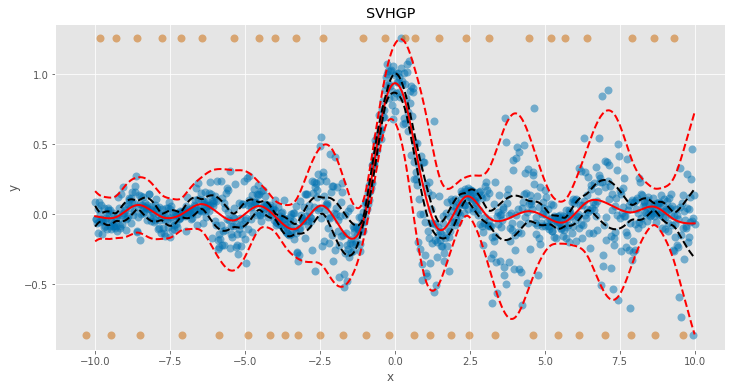

In [10]:
# plot
plt.figure(figsize=(12,6))
plt.plot(X, Y, 'o', color='#0172B2', ms=8, mew=0, alpha=0.5)
plt.plot(zz, Y.max()*np.ones(zz.shape), 'o', color='#CC6600', ms=8, mew=0, alpha=0.5)
plt.plot(zz_g, Y.min()*np.ones(zz_g.shape), 'o', color='#CC6600', ms=8, mew=0, alpha=0.5)
plt.plot(Xs, mu, color='r', lw=2)
plt.plot(Xs, mu + 2*np.sqrt(var), '--', color='r', lw=2)
plt.plot(Xs, mu - 2*np.sqrt(var), '--', color='r', lw=2)
plt.plot(Xs, mu + 2*np.sqrt(var_f), '--', color='k', lw=2)
plt.plot(Xs, mu - 2*np.sqrt(var_f), '--', color='k', lw=2)
plt.title('SVHGP')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In the fig, the top circles are locations of optimized inducing points for latent function f; the bottom circles are locations of optimized inducing points for latent log noise function g; the black dash curves represent the prediction confidence of f; the red dash curves represent the final prediction confidence.